In [1]:
import time
import pickle
from tabulate import tabulate
from IPython.display import display

import pandas as pd
pd.set_option('display.colheader_justify', 'center')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier,RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, f1_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [127]:
randomState = 42
url='Datasets/diabetes_dataset.csv'

def getData(url = url):

    url = url
    df = pd.read_csv(url)
    return df

def cleanData(url = url):

    #Drop duplicates
    print('Dropping duplicates...\n')
    df.drop_duplicates(inplace=True)
    time.sleep(1)

    #Change all column names to lower case
    print('Converting to lower case columns and data...')
    df.columns = df.columns.str.replace('Diabetes_binary','diabetes').str.lower()

    #This next for loop doesn't get executed because there are no "object" type columns
    for col in df.select_dtypes(object).columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    time.sleep(1)

    return df

def splitData(df):

    target = df.diabetes
    data = df.drop(columns=['diabetes'])
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=randomState)
    dfTrain, dfVal, yTrain, yVal = train_test_split(dfTrainFull, yTrainFull, test_size=0.25, random_state=randomState)

    print(  f'Dataset has been split in: Training set with {len(yTrain)} samples, '
            f'Validation set with {len(yVal)} samples and Test set with {len(yTest)} samples')

    return dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest

def printHelper(f1Score, auc):
    
    print('\n---------------------------------')
    print(f'Test set weighted f1-score: {f1Score}')
    print(f'Test set auc: {auc}')
    print('---------------------------------\n')

def printResults(results):  
    print('\n-----------------------------------------')
    for i,j in results.items():
        print('{:<20}:  {:<6}'.format(i, " ± ".join([str(x) for x in j])))
    print('-----------------------------------------')

    
def getMeasures(model):

    yTestpredProb = model.predict_proba(dfTest)[:,1]
    yTestpred = model.predict(dfTest)
    auc = round(roc_auc_score(yTest, yTestpredProb),3)
    f1Score = round(f1_score(yTest, yTestpred, average='weighted'),3)
    modelName = type(model.named_steps.classifier).__name__

    printHelper(f1Score, auc)

    print(classification_report(yTest, yTestpred))

    fig1, ax1 = plt.subplots(figsize=(14, 6))
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, name=f'ROC_AUC {modelName}', )
    ax1.text(0.4,0.5,f'auc = {auc}', size=14, fontweight='semibold', )
    ax1.text(0.4,0.4,f'Weighted f1  = {f1Score}', size=14, fontweight='semibold')
    ax1.legend(loc=4, prop={'size': 20})

    print()

    fig2, ax2 = plt.subplots(1,2, figsize=(16, 6))
    ax2[0].grid(False)
    ax2[1].grid(False)

    cm = confusion_matrix(yTest, yTestpred)
    cmprob = confusion_matrix(yTest, yTestpred, normalize='true')
    cm_display1 = ConfusionMatrixDisplay(cm, display_labels=['No-Diabetes', 'Diabetes'])
    cm_display2 = ConfusionMatrixDisplay(cmprob, display_labels=['No-Diabetes', 'Diabetes'])

    cm_display1.plot(ax=ax2[0])
    cm_display1.ax_.set_title("Confusion Matrix", size=16)
    cm_display2.plot(ax=ax2[1])
    cm_display2.ax_.set_title("Narmalized Confusion Matrix", size=16)

    return [auc], [f1Score]#, yTestpred, yTestpredProb

def getResults(model, params):
    
    baseParams = ["mean_fit_time",
                  "std_fit_time",
                  "mean_train_auc",
                  "std_train_auc",
                  "rank_test_auc",
                  "mean_train_f1_weighted",
                  "std_train_f1_weighted",
                  "rank_test_f1_weighted"
    ]
    
    allParams = baseParams + params
    
    cv_results = pd.DataFrame(model.cv_results_)
    
    res = cv_results[allParams]
    
    rtn = {}
    
    if 'param_classifier__reg_lambda' not in params:
        display(res.query('rank_test_auc < 30 & rank_test_f1_weighted < 30').sort_values(by=["rank_test_auc", "rank_test_f1_weighted"]))
    else:
        display(res.sort_values(by=["rank_test_auc", "rank_test_f1_weighted","mean_fit_time"]).head(20))
    
    rtn['mean_fit_time'] = res['mean_fit_time'].mean()
    rtn['std_fit_time'] = res['std_fit_time'].std()
    
    return rtn

def getBestModelResults(model):
    
    cv_results = cross_validate(model,
                                dfTrainFull,
                                yTrainFull,
                                cv=outerCV,
                                scoring=['f1_weighted','roc_auc'],
                                n_jobs=-1,
                                return_train_score=True,
                                return_estimator=True,
    )

    cv_results = pd.DataFrame(cv_results)
    #print(cv_results)
    cv_test_scores = cv_results[['score_time', 'score_time','test_f1_weighted', 'train_f1_weighted', 'test_roc_auc', 'train_roc_auc']]
    cv_test_scores.columns = ['score_time', 'score_time','val_f1_weighted', 'val_roc_auc','train_f1_weighted', 'train_roc_auc']
    
    print("Scores after hyperparameters tuning:\n")
    
    res = cv_test_scores.copy()
    res.loc['mean'] = res.mean().round(4)
    res.loc['std'] = res.std().round(4)
    
    rtn = {}
    for col in res.columns:
        print(res.loc["mean"][col])
        print(res.loc["std"][col])
        print('{:<20}:  {:<6} +/- {:<6}'.format(col, res.loc["mean"][col], res.loc["std"][col]))
        #print(f'{col}: {res.loc["mean"][col]} +/- {res.loc["std"][col]}')
        rtn[col] = [res.loc["mean"][col], res.loc["std"][col]]
    
    return rtn

def reload(module):
    importlib.reload(module)

### Load binary unbalanced data

In [3]:
df = getData()
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## EDA

#### Preparing and cleaning data

In [4]:
df = cleanData(df)
df

Dropping duplicates...

Converting to lower case columns and data...


,diabetes,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


#### Checking Correlations

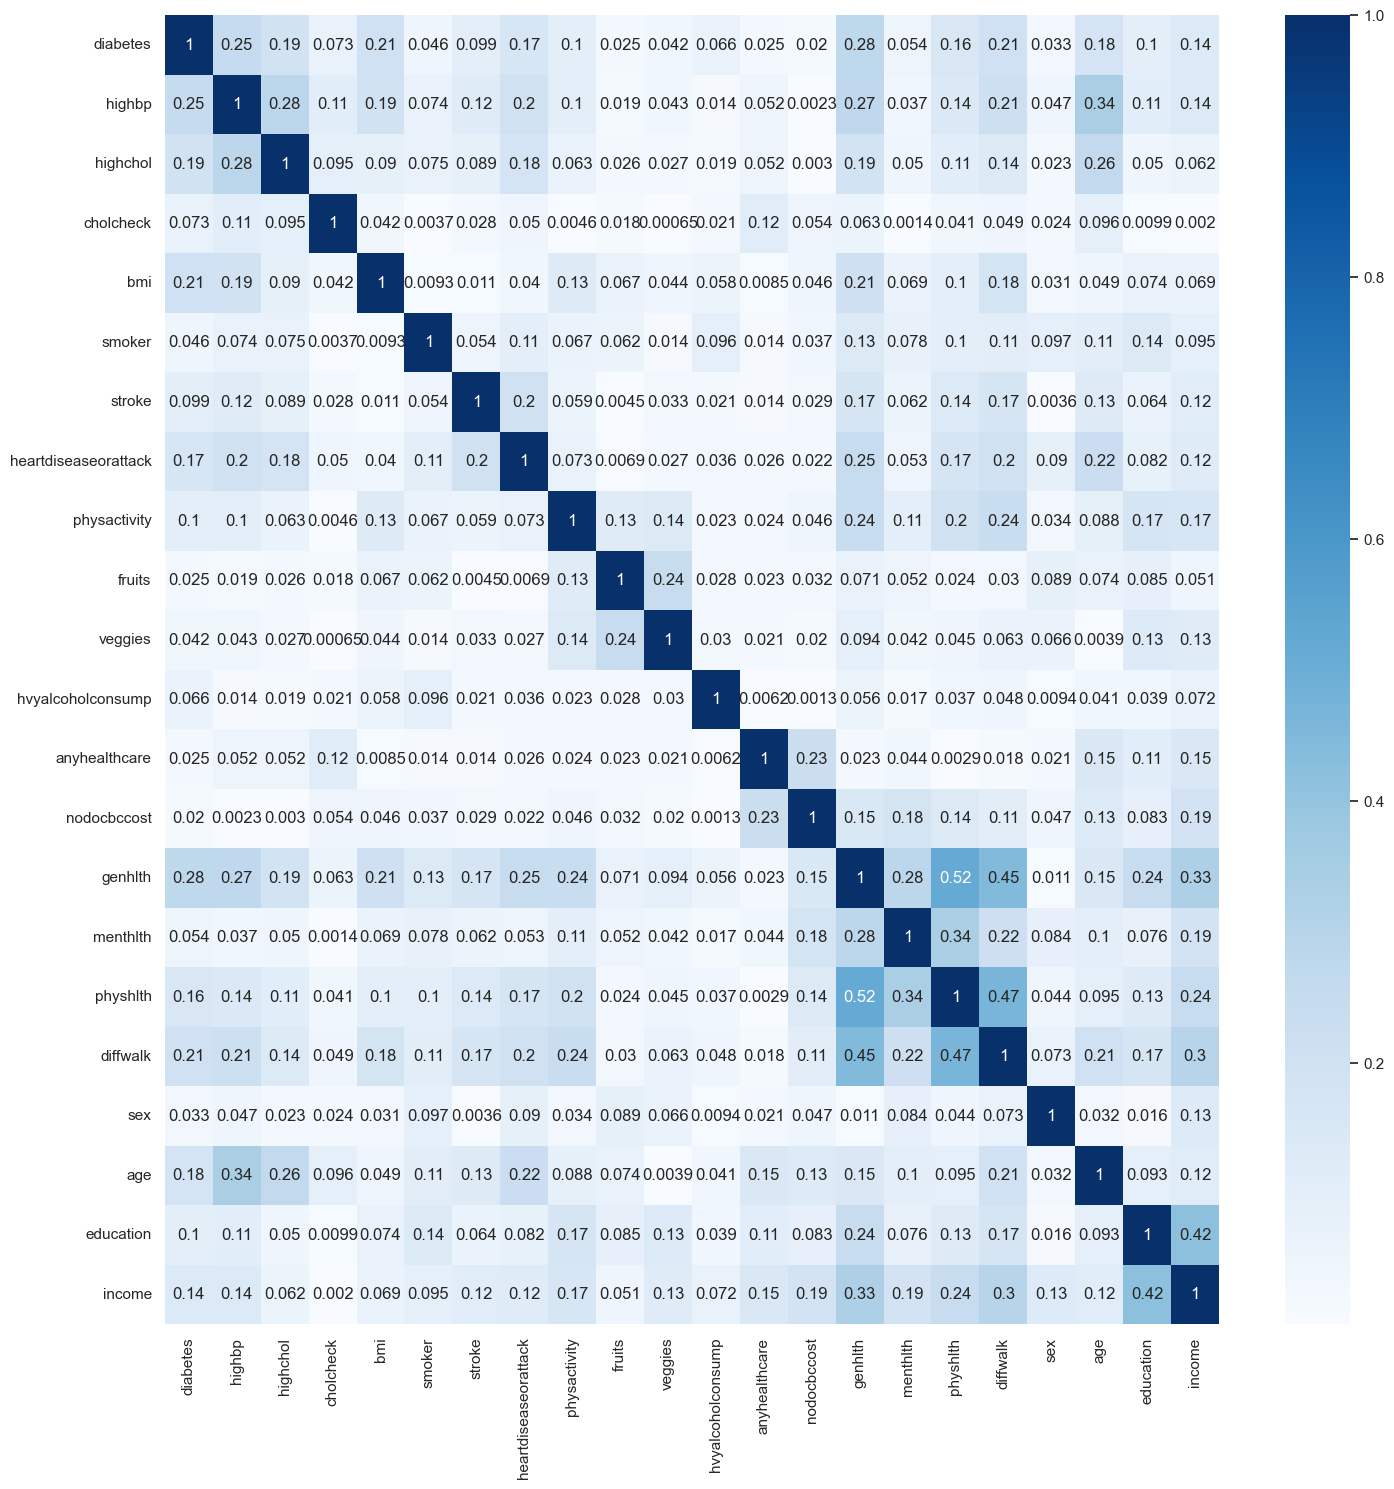

In [5]:
sns.set_theme()
corr_matrix = df.corr().abs()
plt.figure(figsize=(17,17))

_ = sns.heatmap(corr_matrix, cmap="Blues", annot=True)

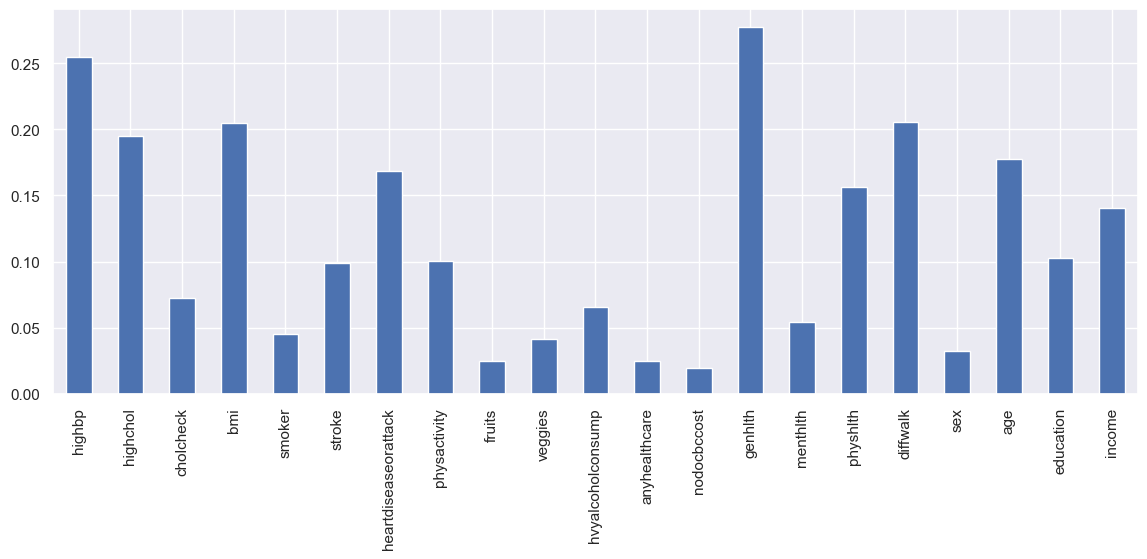

In [6]:
#corr_matrix.diabetes.sort_values(ascending=False).hist()
sns.set_theme()
dfMatrix = df.drop(columns='diabetes')
corr_matrix = dfMatrix.corrwith(df.diabetes).abs()
plt.figure(figsize=(14,5))
_ = corr_matrix.plot(kind='bar', grid=True)
_ = plt.show()    

In [7]:
corr_matrix.sort_values(ascending=False)

genhlth                 0.276940
highbp                  0.254318
diffwalk                0.205302
bmi                     0.205086
highchol                0.194944
age                     0.177263
heartdiseaseorattack    0.168213
physhlth                0.156211
income                  0.140659
education               0.102686
physactivity            0.100404
stroke                  0.099193
cholcheck               0.072523
hvyalcoholconsump       0.065950
menthlth                0.054153
smoker                  0.045504
veggies                 0.041734
sex                     0.032724
anyhealthcare           0.025331
fruits                  0.024805
nodocbccost             0.020048
dtype: float64

#### Dropping columns with lows correlation to avoid overfitting

In [8]:
df.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'veggies'], inplace=True)

#### The target value is heavily imbalanced.  No Diabetes- 194377, Diabetes- 35097.

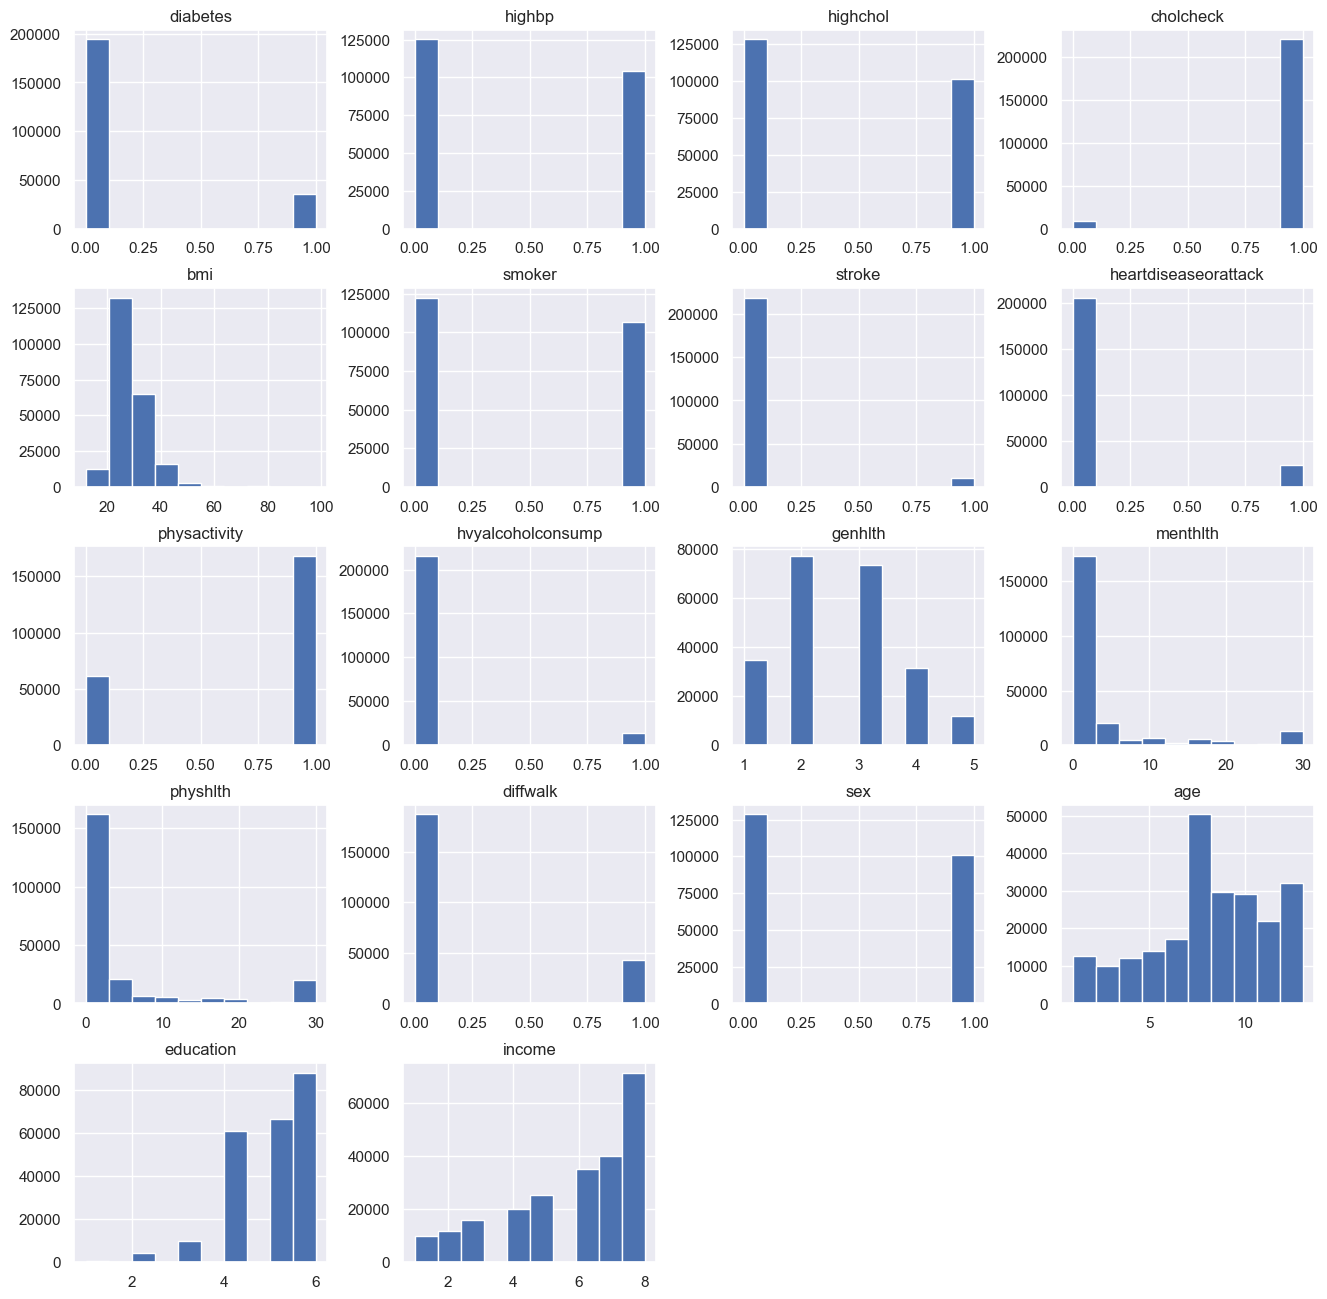

In [9]:
_= df.hist(figsize=(16,16))

In [10]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = splitData(df)

Dataset has been split in: Training set with 137684 samples, Validation set with 45895 samples and Test set with 45895 samples


#### Preprocessing

This part will be used for the Logistic Regression classifier only

In [100]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker','stroke',
                   'heartdiseaseorattack', 'physactivity', 'hvyalcoholconsump',
                   'genhlth','diffwalk', 'sex', 'education']

numericalCols = ['bmi', 'menthlth', 'physhlth', 'income']

In [101]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")

## ML Models

#### Setting up some variables

In [102]:
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)
# Outer cross-validation(for testing the tunned model)
outerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}


### DecisionTreeClassifier

#### Will use nested CrossValidation

inner cross-validation(for Hyperparameter tuning)

In [14]:
%%time

# Model
model_DT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state = randomState))])

# Gridsearch params
param_grid = {
    'classifier__max_depth': (1,3,5,7,10),
    'classifier__max_leaf_nodes': (1, 5,10,15,20),
    'classifier__max_features': (1,3,5,7,10,15)
}

# Gridsearch
model_grid_search_DT = GridSearchCV(model_DT,
                                    param_grid=param_grid,
                                    scoring=scoring,
                                    n_jobs=-1,
                                    cv=innerCV,
                                    return_train_score=True,
                                    refit=False)

_ = model_grid_search_DT.fit(dfTrainFull, yTrainFull)

Wall time: 1min 10s


In [103]:
paramsDT = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

results = {}

results = getResults(model_grid_search_DT, paramsDT)

,mean_fit_time,std_fit_time,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
89,0.915650,0.011901,0.785094,0.000679,1,0.736637,0.011232,21,5,20,15
119,0.888671,0.023456,0.785204,0.000760,2,0.753910,0.005530,11,7,20,15
149,0.909079,0.046232,0.785204,0.000760,2,0.753910,0.005530,11,10,20,15
114,0.696261,0.009956,0.783854,0.000769,4,0.735087,0.011630,22,7,20,10
144,0.745039,0.061156,0.783854,0.000769,4,0.735087,0.011630,22,10,20,10
84,0.724205,0.033594,0.783589,0.000436,6,0.738683,0.009052,16,5,20,10
88,0.852106,0.064519,0.780232,0.000794,7,0.732379,0.014683,27,5,15,15
118,0.864419,0.017356,0.780232,0.000794,7,0.732379,0.014683,27,7,15,15
148,0.880788,0.063889,0.780232,0.000794,7,0.732379,0.014683,27,10,15,15
87,0.870736,0.047038,0.770915,0.000649,13,0.733105,0.010321,24,5,10,15


#### Selecting best parameters
We will choose max_depth=7, max_features=5 and max_leaf_nodes=20. Reaching a compromise between F1 Score and AUC.

In [16]:
%%time

bestParamsDT = ['max_depth=7', 'max_leaf_nodes=20', 'max_features=5']

modelDT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced',
                                                        random_state = randomState,
                                                        max_depth=7,
                                                        max_leaf_nodes=20,
                                                        max_features=15))])

_ = modelDT.fit(dfTrainFull, yTrainFull)

Wall time: 289 ms


Outer cross-validation(for testing the tunned model)

{'mean_fit_time': 0.3994988152186077, 'std_fit_time': 0.01822742519214295}

In [128]:
results.update(getBestModelResults(modelDT))
results

Scores after hyperparameters tuning:

score_time    0.0437
score_time    0.0437
Name: mean, dtype: float64
score_time    0.0017
score_time    0.0017
Name: std, dtype: float64


TypeError: unsupported format string passed to Series.__format__

#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.737
Test set auc: 0.783
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     38813
           1       0.30      0.75      0.43      7082

    accuracy                           0.70     45895
   macro avg       0.62      0.72      0.61     45895
weighted avg       0.84      0.70      0.74     45895




TypeError: list indices must be integers or slices, not str

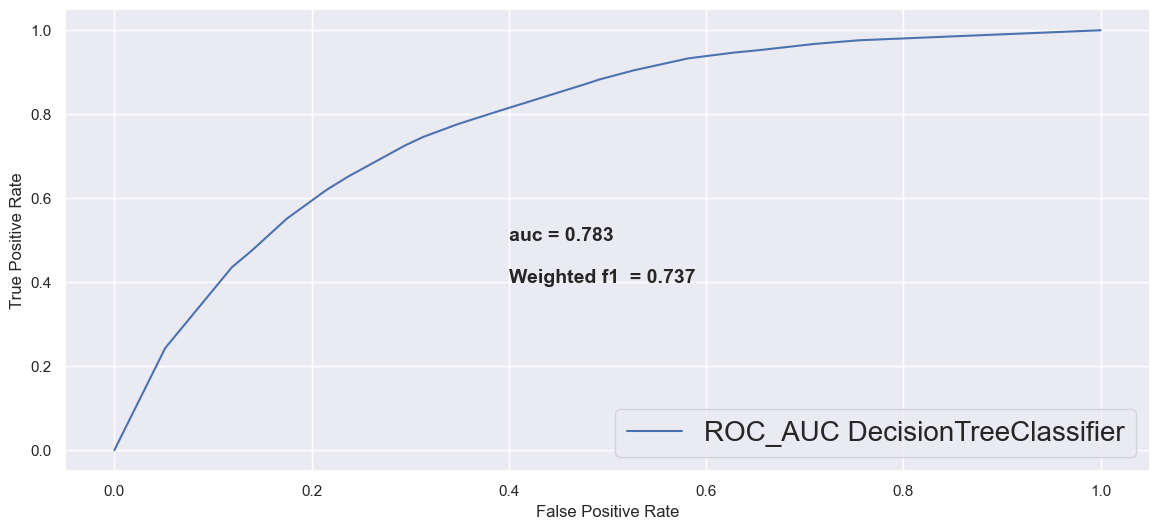

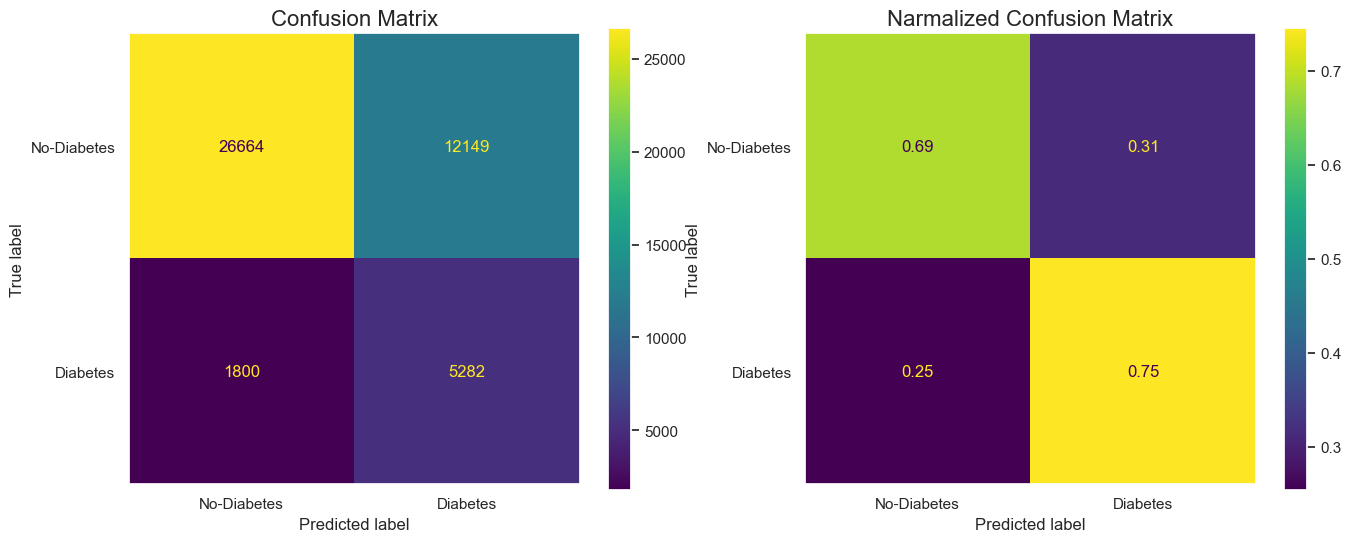

In [72]:
results['test_roc'], results['test_f1-score'] = getMeasures(modelDT)

### DecisionTreeClassifier results:

In [19]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.744 ± 0.0132
val_roc_auc         :  0.7442 ± 0.0136
train_f1_weighted   :  0.7834 ± 0.0004
train_roc_auc       :  0.785 ± 0.0008
test_roc            :  0.783 
test_f1-score       :  0.737 
-----------------------------------------


### Logistic Regression

In [20]:
%%time

model_LR = Pipeline([("processor", preprocessor),
                  ("classifier", LogisticRegression(max_iter=1000,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

param_grid = {
    'classifier__C': (1e-3, 1e-2, 0.1, 1, 5, 10, 20),
}
scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_LR = GridSearchCV(model_LR,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_LR.fit(dfTrainFull, yTrainFull)

Wall time: 1min 42s


In [21]:
paramsLR = ["param_classifier__C"]

getResults(model_grid_search_LR, paramsLR)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__C
1,0.807584,0.000655,1,0.753678,0.000696,2,0.01
2,0.807535,0.000655,2,0.753413,0.000691,3,0.1
6,0.807523,0.000659,3,0.753359,0.000758,7,20
4,0.807523,0.000656,4,0.753387,0.000723,6,5
3,0.807523,0.000658,5,0.753373,0.000780,5,1
5,0.807524,0.000658,6,0.753376,0.000749,4,10
0,0.806329,0.000636,7,0.754133,0.000521,1,0.001


#### Selecting best parameters
Choosing C=0.1, in this case it's the beast AUC and 2nd best F1 Score

In [22]:
%%time

modelLR = Pipeline([("classifier", LogisticRegression(max_iter=1000,
                                                    C=0.01,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

_ = modelLR.fit(dfTrainFull, yTrainFull)

Wall time: 5.81 s


Outer cross-validation(for testing the tunned model)

In [23]:
results = getBestModelResults(modelLR)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7555 +/- 0.0008
val_roc_auc         :  0.7555 +/- 0.0007
train_f1_weighted   :  0.8071 +/- 0.0014
train_roc_auc       :  0.8072 +/- 0.0007


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.756
Test set auc: 0.809
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     38813
           1       0.32      0.75      0.45      7082

    accuracy                           0.72     45895
   macro avg       0.63      0.73      0.63     45895
weighted avg       0.85      0.72      0.76     45895




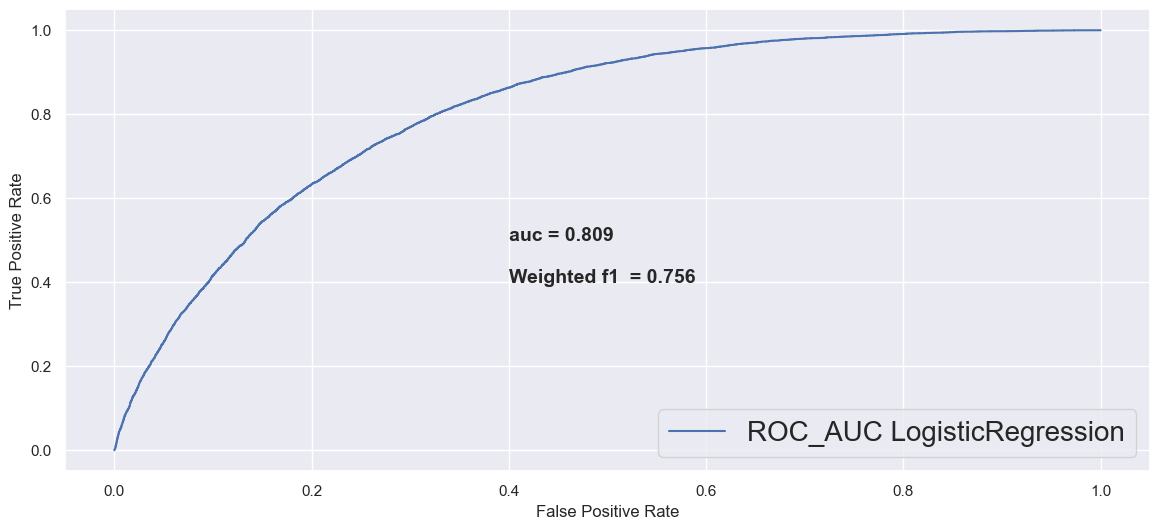

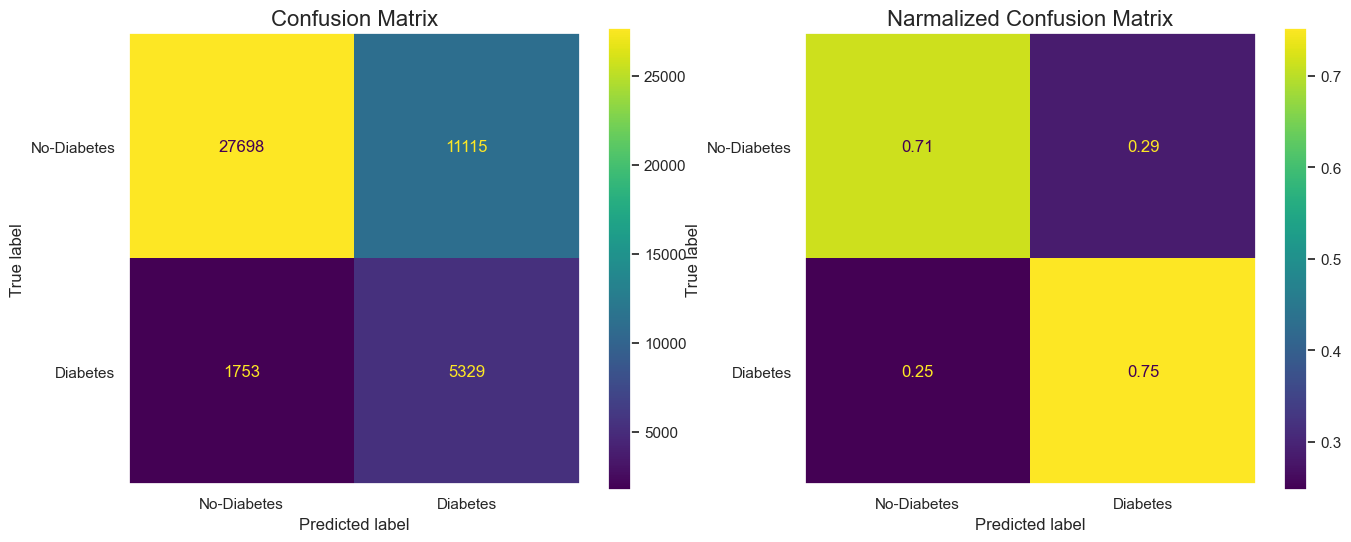

In [24]:
results['test_roc'], results['test_f1-score'] = getMeasures(modelLR)

### Logistic Regression results:

In [25]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7555 ± 0.0008
val_roc_auc         :  0.7555 ± 0.0007
train_f1_weighted   :  0.8071 ± 0.0014
train_roc_auc       :  0.8072 ± 0.0007
test_roc            :  0.809 
test_f1-score       :  0.756 
-----------------------------------------


### Random Forest

In [26]:
%%time

model_RF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                           class_weight='balanced',
                                                           random_state=randomState))])

param_grid = {
    'classifier__max_depth': (5,10,15,20,25),
    'classifier__max_leaf_nodes': (5,10,15,20,30),
    'classifier__max_features': (3,5,7,10)
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_RF = GridSearchCV(model_RF,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_RF.fit(dfTrainFull, yTrainFull)

Wall time: 3min 48s


In [27]:
paramsRF = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

getResults(model_grid_search_RF, paramsRF)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
29,0.802340,0.000626,5,0.744041,0.004599,6,10,30,5
49,0.802340,0.000626,5,0.744041,0.004599,6,15,30,5
69,0.802340,0.000626,5,0.744041,0.004599,6,20,30,5
89,0.802340,0.000626,5,0.744041,0.004599,6,25,30,5
39,0.801733,0.000766,9,0.742631,0.004675,11,10,30,10
59,0.801733,0.000766,9,0.742631,0.004675,11,15,30,10
79,0.801733,0.000766,9,0.742631,0.004675,11,20,30,10
99,0.801733,0.000766,9,0.742631,0.004675,11,25,30,10
34,0.801186,0.000974,13,0.741562,0.004339,21,10,30,7
54,0.801186,0.000974,13,0.741562,0.004339,21,15,30,7


#### Selecting best parameters
Choosing max_depth = 10, max_leaf_nodes=30 and max_features=10. It's a good AUC and a good F1 Score

In [28]:
%%time

modelRF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                          max_depth = 10,
                                                          max_leaf_nodes=30,
                                                          max_features=10,
                                                          class_weight='balanced',
                                                          random_state=randomState))])

_ = modelRF.fit(dfTrainFull, yTrainFull)

Wall time: 2.2 s


Outer cross-validation(for testing the tuned model)

In [29]:
results = getBestModelResults(modelRF)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7398 +/- 0.0021
val_roc_auc         :  0.7405 +/- 0.0019
train_f1_weighted   :  0.8002 +/- 0.0006
train_roc_auc       :  0.8024 +/- 0.0011


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.743
Test set auc: 0.798
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.69      0.80     38813
           1       0.31      0.75      0.44      7082

    accuracy                           0.70     45895
   macro avg       0.62      0.72      0.62     45895
weighted avg       0.84      0.70      0.74     45895




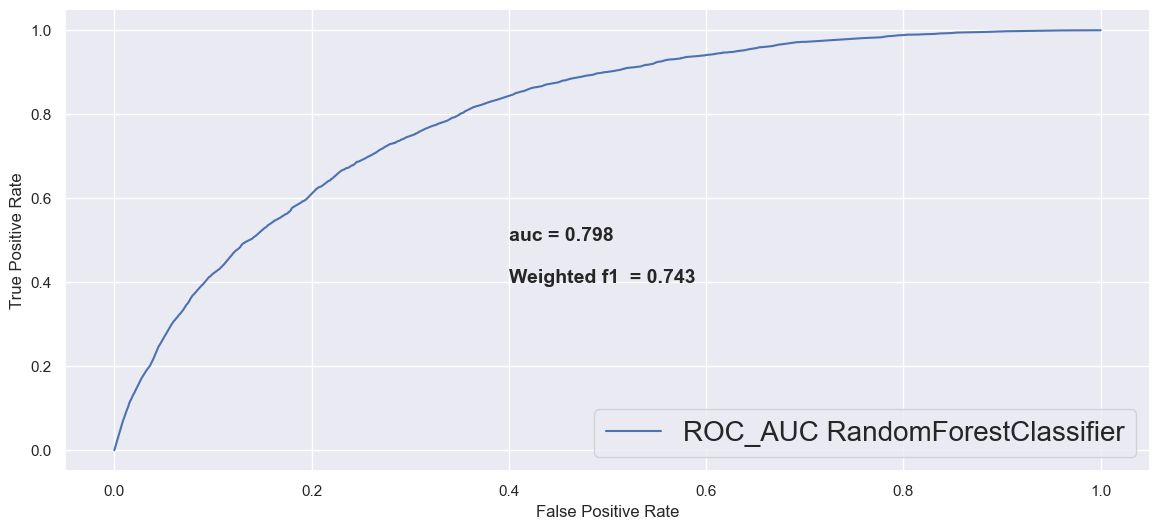

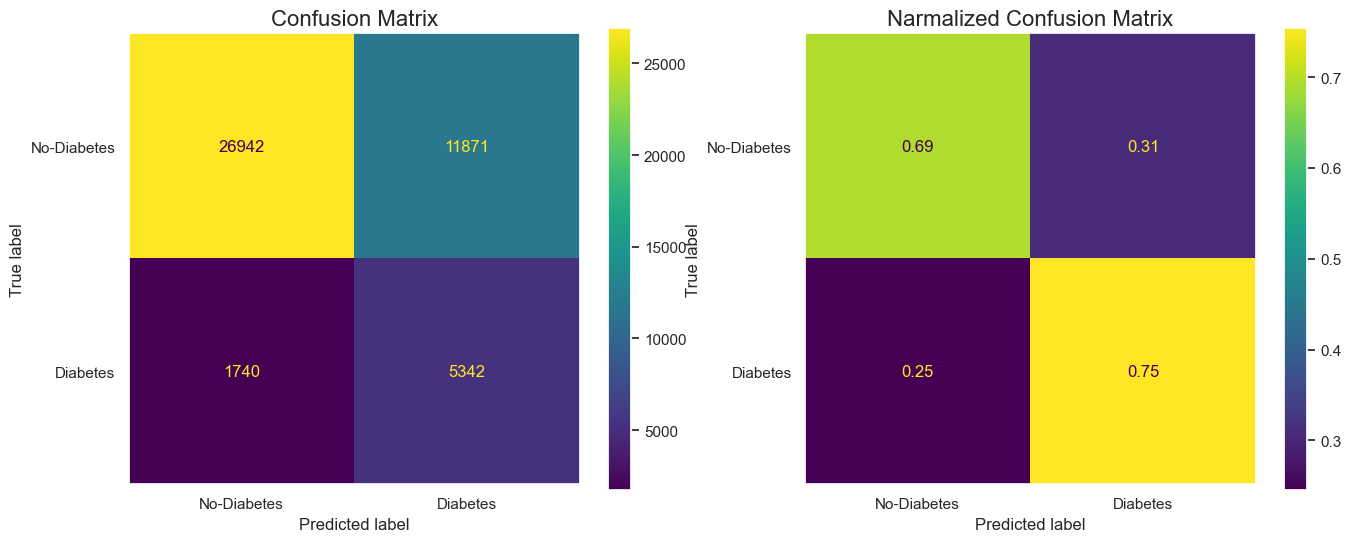

In [30]:
results['test_roc'], results['test_f1-score'] = getMeasures(modelRF)

### Random Forest results:

In [31]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7398 ± 0.0021
val_roc_auc         :  0.7405 ± 0.0019
train_f1_weighted   :  0.8002 ± 0.0006
train_roc_auc       :  0.8024 ± 0.0011
test_roc            :  0.798 
test_f1-score       :  0.743 
-----------------------------------------


### XGBoost Classifier

In [32]:
imbalanceRatio = (yTrainFull==0).sum() / (yTrainFull==1).sum()
imbalanceRatio = round(imbalanceRatio, 2)
imbalanceRatio

5.55

In [33]:
%%time
# 58 min 15 s
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

model_XGB = Pipeline([("classifier", XGBClassifier(n_estimators=10,
                                                   random_state=randomState, 
                                                   tree_method='gpu_hist',
                                                   scale_pos_weight=imbalanceRatio)
                      )])

param_grid = {
    'classifier__max_depth' : (2, 5, 8, 10),
    'classifier__learning_rate' : (0.01, 0.1, 0.5, 0.8),
    'classifier__min_child_weight' : (1,10,20),
    'classifier__reg_lambda' : (1, 3, 5, 8),
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_XGB = GridSearchCV(model_XGB,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 verbose=4,                                 
                                 refit=False)

_ = model_grid_search_XGB.fit(dfTrain, yTrain)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Wall time: 1min 26s


In [34]:
paramsXGB = ["param_classifier__max_depth",
             'param_classifier__learning_rate',
             "param_classifier__min_child_weight",
             "param_classifier__reg_lambda"]

getResults(model_grid_search_XGB, paramsXGB)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__min_child_weight,param_classifier__reg_lambda
110,0.819318,0.000910,1,0.748177,0.001001,118,5,0.5,1,5
109,0.819561,0.000760,2,0.749020,0.001498,107,5,0.5,1,3
113,0.819035,0.001251,3,0.747816,0.001974,122,5,0.5,10,3
114,0.819174,0.000985,4,0.749476,0.000682,98,5,0.5,10,5
117,0.818572,0.001018,5,0.748686,0.000818,103,5,0.5,20,3
111,0.819470,0.000988,6,0.749011,0.001196,101,5,0.5,1,8
119,0.818934,0.001035,7,0.748620,0.001684,100,5,0.5,20,8
115,0.819050,0.000779,8,0.748863,0.001089,99,5,0.5,10,8
118,0.818901,0.001172,9,0.748332,0.000513,111,5,0.5,20,5
108,0.819537,0.001182,10,0.749239,0.000622,106,5,0.5,1,1


#### Selecting best parameters
Choosing max_depth = 8, learning_rate = 0.5, min_child_weight = 20 and reg_lambda = 8,. It's a good compromise between a good AUC and F1 Score

In [35]:
%%time

modelXGB = Pipeline([("classifier", XGBClassifier(n_estimators = 10,
                                                  max_depth = 5,
                                                  learning_rate = 0.8,
                                                  min_child_weight = 10,
                                                  reg_lambda = 8,
                                                  random_state=randomState, 
                                                  tree_method='gpu_hist',
                                                  scale_pos_weight=imbalanceRatio))
                    ])

_ = modelXGB.fit(dfTrainFull, yTrainFull)

Wall time: 568 ms


Outer cross-validation(for testing the tuned model)

In [36]:
results = getBestModelResults(modelXGB)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7452 +/- 0.002 
val_roc_auc         :  0.7483 +/- 0.002 
train_f1_weighted   :  0.8109 +/- 0.0016
train_roc_auc       :  0.8199 +/- 0.0011


#### Curves and measures of error


---------------------------------
Test set weighted f1-score: 0.745
Test set auc: 0.812
---------------------------------

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     38813
           1       0.32      0.78      0.45      7082

    accuracy                           0.70     45895
   macro avg       0.63      0.74      0.62     45895
weighted avg       0.85      0.70      0.74     45895




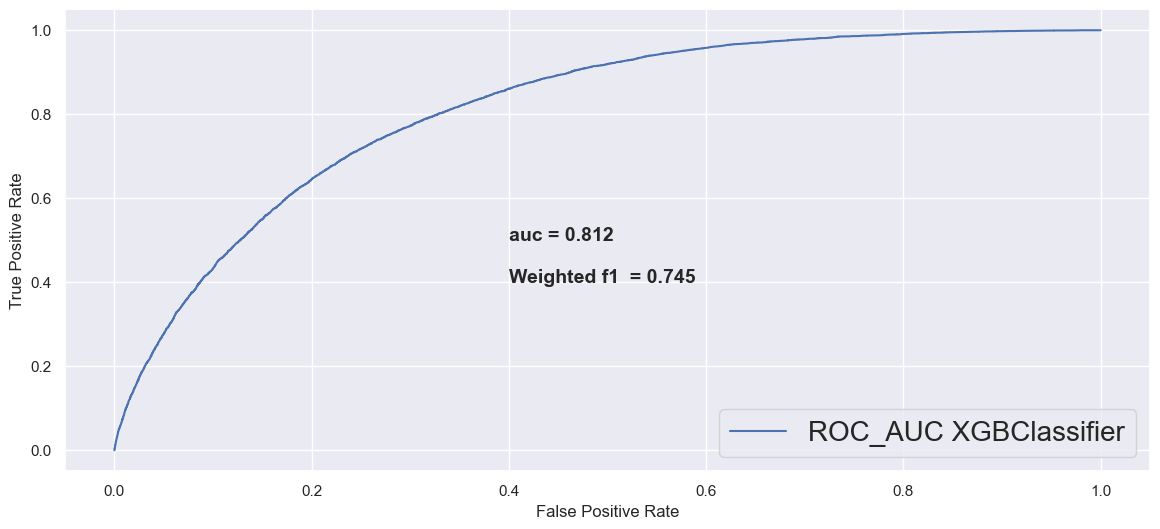

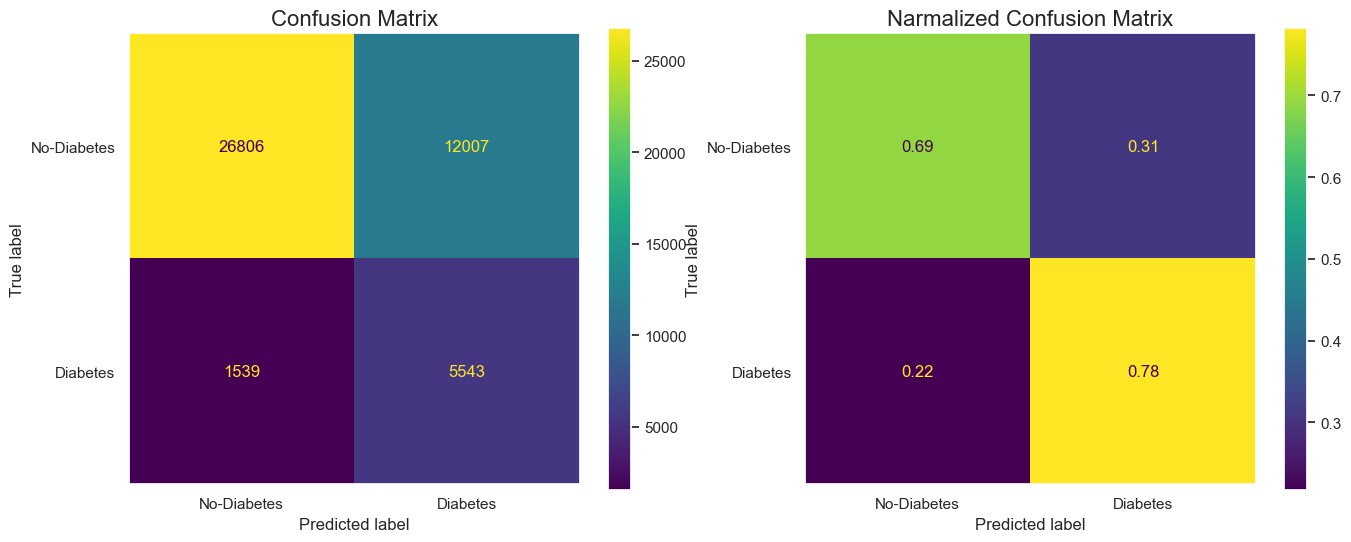

In [37]:
results['test_roc'], results['test_f1-score'] = getMeasures(modelXGB)

### XGBoost results:

In [38]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7452 ± 0.002
val_roc_auc         :  0.7483 ± 0.002
train_f1_weighted   :  0.8109 ± 0.0016
train_roc_auc       :  0.8199 ± 0.0011
test_roc            :  0.812 
test_f1-score       :  0.745 
-----------------------------------------


### AdaBoostClassifier

In [39]:
%%time
model_AB = Pipeline([("classifier", AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),
                                                       random_state=randomState)
                      )])

param_grid = {
    'classifier__learning_rate' : (0.1, 0.5, 1, 2),
    'classifier__base_estimator__class_weight': [None, 'balanced'],
    'classifier__base_estimator__max_depth': [1, 3, 5],
    'classifier__base_estimator__max_leaf_nodes': [1, 3, 5],
    
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_AB = GridSearchCV(model_AB,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 verbose=4,                                 
                                 refit=False)

_ = model_grid_search_AB.fit(dfTrainFull, yTrainFull)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Wall time: 9min 5s


In [40]:
paramsAB = ['param_classifier__learning_rate',
            'param_classifier__base_estimator__class_weight',
            'param_classifier__base_estimator__max_depth',
            'param_classifier__base_estimator__max_leaf_nodes'
           ]

getResults(model_grid_search_AB, paramsAB)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__learning_rate,param_classifier__base_estimator__class_weight,param_classifier__base_estimator__max_depth,param_classifier__base_estimator__max_leaf_nodes
57,0.817406,0.000472,1,0.749077,0.002192,27,0.5,balanced,3,5
17,0.815079,0.000681,2,0.820722,0.000457,1,0.5,None,3,3
29,0.815079,0.000681,2,0.820722,0.000457,1,0.5,None,5,3
33,0.817700,0.000787,4,0.819499,0.001284,9,0.5,None,5,5
69,0.817323,0.000689,5,0.747940,0.002196,28,0.5,balanced,5,5
21,0.817390,0.000915,6,0.819481,0.001387,8,0.5,None,3,5
18,0.815082,0.000976,9,0.819940,0.000571,3,1,None,3,3
30,0.815082,0.000976,9,0.819940,0.000571,3,1,None,5,3
54,0.815383,0.000664,11,0.747881,0.001906,29,1,balanced,3,3
66,0.815383,0.000664,11,0.747881,0.001906,29,1,balanced,5,3


#### Selecting best parameters
Choosing max_depth = 3, max_leaf_nodes= 3  and learning_rate = 0.8 and class_weight = None.

In [41]:
%%time

modelAB = Pipeline([("classifier", AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(class_weight = 'balanced',
                                            max_depth = 1,
                                            max_leaf_nodes = 5,
                                           ), learning_rate = 1.0, random_state=randomState))
                   ])

_ = modelAB.fit(dfTrainFull, yTrainFull)

Wall time: 5.88 s


Outer cross-validation(for testing the tuned model)

In [42]:
results = getBestModelResults(modelAB)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7551 +/- 0.0015
val_roc_auc         :  0.7554 +/- 0.001 
train_f1_weighted   :  0.8116 +/- 0.001 
train_roc_auc       :  0.8126 +/- 0.0006


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.756
Test set auc: 0.813
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     38813
           1       0.33      0.76      0.46      7082

    accuracy                           0.72     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.72      0.76     45895




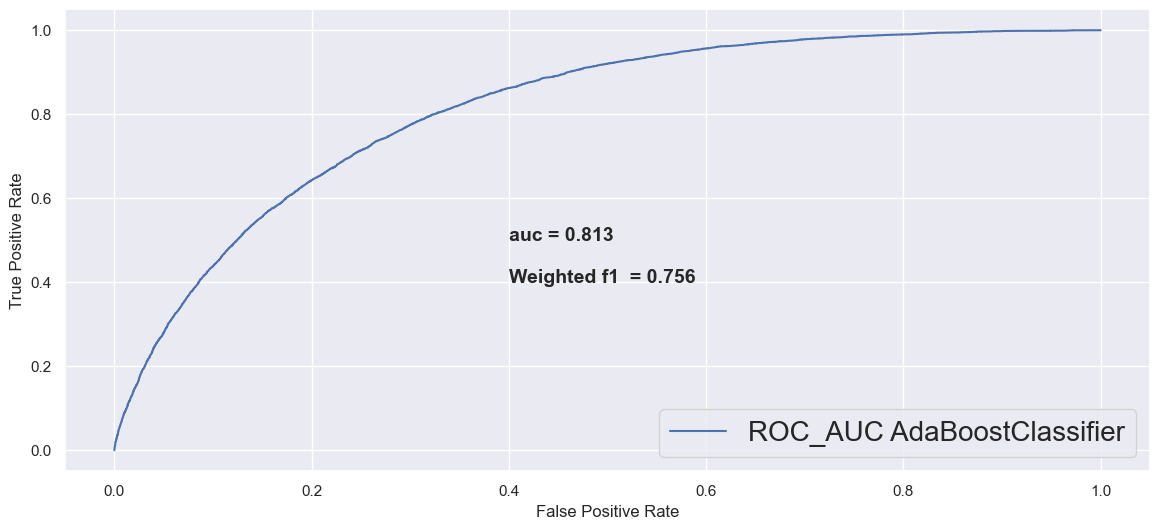

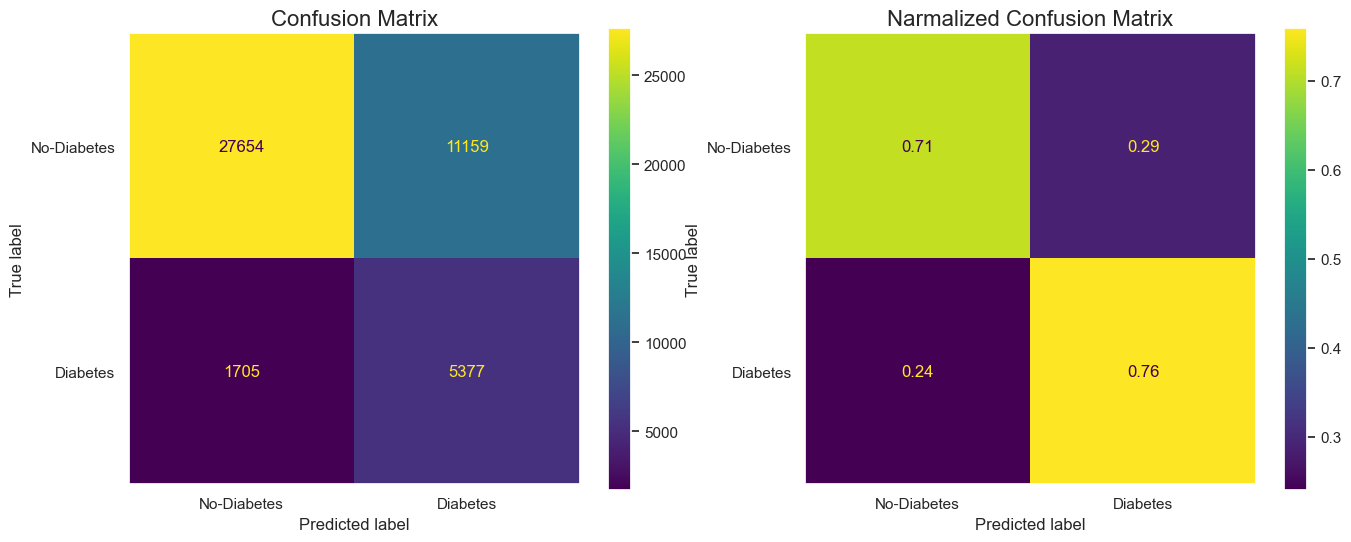

In [43]:
results['test_roc'], results['test_f1-score'] = getMeasures(modelAB)

### AdaBoostClassifier results:

In [44]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7551 ± 0.0015
val_roc_auc         :  0.7554 ± 0.001
train_f1_weighted   :  0.8116 ± 0.001
train_roc_auc       :  0.8126 ± 0.0006
test_roc            :  0.813 
test_f1-score       :  0.756 
-----------------------------------------


## Comparing models

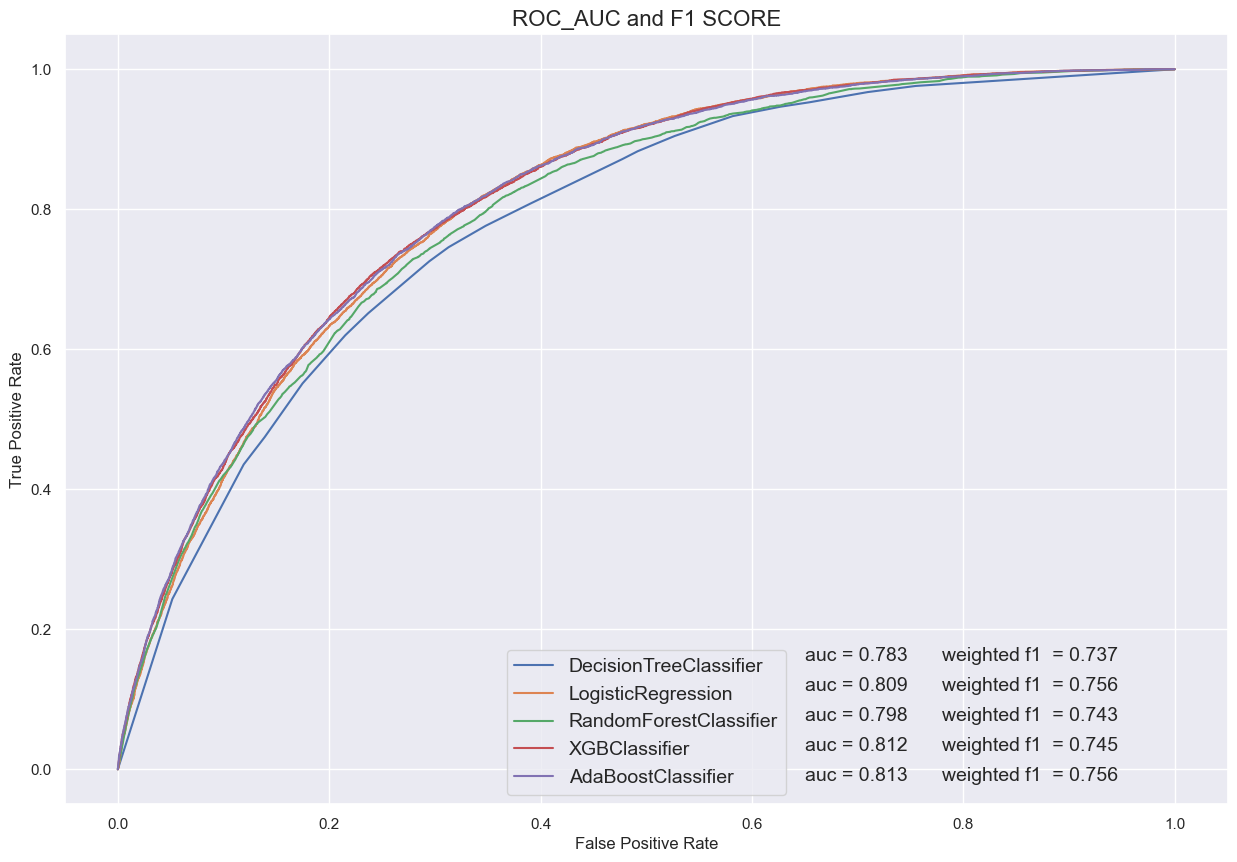

In [45]:
models = [modelDT, modelLR, modelRF, modelXGB, modelAB]

fig, ax = plt.subplots(figsize=(15, 10))
delta = 0

for model in models:

    yTestpredProb_ = model.predict_proba(dfTest)[:,1]
    yTestpred_ = model.predict(dfTest)
    modelName = type(model.named_steps.classifier).__name__
    
    auc = round(roc_auc_score(yTest, yTestpredProb_),3)
    f1Score = round(f1_score(yTest, yTestpred_, average='weighted'),3)
    
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb_)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_display1.plot(ax=ax, name=modelName)
    #roc_display1.ax_.(linestyle='dashed', marker='o')
    roc_display1.ax_.set_title('ROC_AUC and F1 SCORE', size= 16)
    ax.text(0.65, 0.155 - delta, f'auc = {auc}', size=14 )
    ax.text(0.78, 0.155 - delta, f'weighted f1  = {f1Score}', size=14)
    ax.legend(loc='lower center', prop={'size': 14})
    delta += 0.043  

#### In this case the best model is the AdaBoostClassifier.

## Saving Models with Pickle

In [46]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

models = [modelDT, modelLR, modelRF, modelXGB, modelAB]
for model in models:
    modelName = type(model.named_steps.classifier).__name__
    print(f'Saving pickle file for {modelName}')
    outputFile = f'models/{modelName}.bin'
    with open(outputFile, 'wb') as f:
        pickle.dump(model, f)

Saving pickle file for DecisionTreeClassifier
Saving pickle file for LogisticRegression
Saving pickle file for RandomForestClassifier
Saving pickle file for XGBClassifier
Saving pickle file for AdaBoostClassifier


## Testing model predictions

In [47]:
inputData = {
    'highbp': 'No',
    'highchol': 'Yes',
     'cholcheck': 'Yes',
     'bmi': 27,
     'smoker': 'Yes',
     'stroke': 'No',
     'heartdiseaseorattack': 'No',
     'physactivity': 'No',
     'fruits': 'Yes',
     'veggies': 'Yes',
     'hvyalcoholconsump': 'No',
     'anyhealthcare': 'No',
     'nodocbccost': 'No',
     'genhlth': 'Yes',
     'menthlth': 0,
     'physhlth': 0,
     'diffwalk': 'No',
     'sex': 'Female',
     'age': 25,
     'education': 'Some high school',
     'income': '$25,000 to $35,000'
}
inputData

{'highbp': 'No',
 'highchol': 'Yes',
 'cholcheck': 'Yes',
 'bmi': 27,
 'smoker': 'Yes',
 'stroke': 'No',
 'heartdiseaseorattack': 'No',
 'physactivity': 'No',
 'fruits': 'Yes',
 'veggies': 'Yes',
 'hvyalcoholconsump': 'No',
 'anyhealthcare': 'No',
 'nodocbccost': 'No',
 'genhlth': 'Yes',
 'menthlth': 0,
 'physhlth': 0,
 'diffwalk': 'No',
 'sex': 'Female',
 'age': 25,
 'education': 'Some high school',
 'income': '$25,000 to $35,000'}

In [48]:
#Transform inputdata to an inputdataframe
data = pd.DataFrame(inputData, index=[1])
data.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'veggies'], inplace=True)
# Mappings
sex = {'Male':0, 'Female':1}
binary = {'Yes': 1, 'No': 0}
education = {'Never attended school or only kindergarten' : 1,
             'Elementary school' : 2,
             'Some high school' : 3,
             'High school graduate' : 4,
             'Some college or technical school' : 5,
             'College graduate' : 6 }
income = {'less than $10,000'  : 1,
          '$10,000 to $15,000' : 2,
          '$15,000 to $20,000' : 3, 
          '$20,000 to $25,000' : 4,
          '$25,000 to $35,000' : 5,
          '$35,000 to $50,000' : 6,
          '$50,000 to $75,000' : 7,
          '$75,000 or  more'   : 8}


def getAgeRange(age):
    
    if 18 <= age <= 24:
        ageRange = 1
    elif 25 <= age <= 29:
        ageRange = 2
    elif 30 <= age <= 34: 
        ageRange = 3
    elif 35 <= age <= 39: 
        ageRange = 4
    elif 40 <= age <= 44:
        ageRange = 5
    elif 45 <= age <= 49:
        ageRange = 6
    elif 50 <= age <= 54:
        ageRange = 7
    elif 55 <= age <= 59:
        ageRange = 8
    elif 60 <= age <= 64:
        ageRange = 9
    elif 65 <= age <= 69:
        ageRange = 10
    elif 70 <= age <= 74:
        ageRange = 11
    elif 75 <= age <= 79:
        ageRange = 12
    elif 80 <= age:
        ageRange = 13
    return ageRange

ageRange = getAgeRange(data.age.values)


In [49]:
# Replace values
data.replace( binary | sex | education | income , inplace=True)
data.age = ageRange

# get models from folder and load models to a dictionary
path = 'models/'
files = os.listdir(path)
models = {}

for file in files:
    filename = file.split('.')[0]
    with open('models/' + file, 'rb') as f:
        models[filename] = pickle.load(f)        

# Make predictions
for name, model in models.items():
    yProb_ = model.predict_proba(data)[:,1]
    yPred_ = model.predict(data)
    print(f'{name:<22} : {yProb_} = {yPred_}')

AdaBoostClassifier     : [0.48395077] = [0]
DecisionTreeClassifier : [0.10378588] = [0]
LogisticRegression     : [0.10840676] = [0]
RandomForestClassifier : [0.07457761] = [0]
XGBClassifier          : [0.01563499] = [0]


In [50]:
inputData2 = {
    'highbp': 'No',
    'highchol': 'Yes',
    'cholcheck': 'Yes',
    'bmi': 30,
    'smoker': 'Yes',
    'stroke': 'No',
    'heartdiseaseorattack': 'No',
    'physactivity': 'Yes',
    'fruits': 'Yes',
    'veggies': 'Yes',
    'hvyalcoholconsump': 'No',
    'anyhealthcare': 'Yes',
    'nodocbccost': 'No',
    'genhlth': 'Yes',
    'menthlth': 'No',
    'physhlth': 'No',
    'diffwalk': 'No',
    'sex': 'Male',
    'age': 57,
    'education': 'High school graduate',
    'income': '$75,000 or  more'}

In [51]:
# Replace values
data.replace( binary | sex | education | income , inplace=True)
data.age = ageRange

# get models from folder and load models to a dictionary
path = 'models/'
files = os.listdir(path)
models = {}

for file in files:
    filename = file.split('.')[0]
    with open('models/' + file, 'rb') as f:
        models[filename] = pickle.load(f) 
        
# Make predictions
for name, model in models.items():
    yProb_ = model.predict_proba(data)[:,1]
    yPred_ = model.predict(data)
    print(f'{name:<22} : {yProb_} = {yPred_}')        

AdaBoostClassifier     : [0.48395077] = [0]
DecisionTreeClassifier : [0.10378588] = [0]
LogisticRegression     : [0.10840676] = [0]
RandomForestClassifier : [0.07457761] = [0]
XGBClassifier          : [0.01563499] = [0]


In [52]:
model_grid_search_DT.cv_results_

{'mean_fit_time': array([0.12440519, 0.15799751, 0.16320024, 0.17847052, 0.20199723,
        0.18420091, 0.24547915, 0.24500957, 0.23100238, 0.23604584,
        0.18840022, 0.26771507, 0.25389938, 0.27327991, 0.28503118,
        0.19600863, 0.27540021, 0.30240068, 0.29039817, 0.28420019,
        0.17339654, 0.30320735, 0.3282877 , 0.31259789, 0.30579891,
        0.18356595, 0.37783122, 0.39340215, 0.38582535, 0.36191735,
        0.2044127 , 0.2446156 , 0.26101732, 0.23430033, 0.24301929,
        0.18120155, 0.34470673, 0.35605893, 0.34358654, 0.35879102,
        0.2087997 , 0.38940334, 0.40220098, 0.396804  , 0.37316527,
        0.17280402, 0.42019939, 0.47405834, 0.41160407, 0.44831314,
        0.18000131, 0.46965189, 0.47995448, 0.48704123, 0.54319501,
        0.16879892, 0.63446336, 0.62761302, 0.59316859, 0.64856277,
        0.17780352, 0.24056568, 0.26279488, 0.30760465, 0.2867938 ,
        0.19190464, 0.34835768, 0.38010545, 0.39390965, 0.38260155,
        0.17520256, 0.37560735,

In [57]:
pd.DataFrame(model_grid_search_AB.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__base_estimator__class_weight,param_classifier__base_estimator__max_depth,param_classifier__base_estimator__max_leaf_nodes,param_classifier__learning_rate,params,split0_test_auc,...,split1_test_f1_weighted,split2_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted
0,0.127338,0.032720,0.000000,0.000000,None,1,1,0.1,{'classifier__base_estimator__class_weight': N...,NaN,...,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN,NaN
1,0.119330,0.011438,0.000000,0.000000,None,1,1,0.5,{'classifier__base_estimator__class_weight': N...,NaN,...,NaN,NaN,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN
2,0.132659,0.021795,0.000000,0.000000,None,1,1,1,{'classifier__base_estimator__class_weight': N...,NaN,...,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,NaN
3,0.130003,0.008604,0.000000,0.000000,None,1,1,2,{'classifier__base_estimator__class_weight': N...,NaN,...,NaN,NaN,NaN,NaN,52,NaN,NaN,NaN,NaN,NaN
4,12.932263,0.583762,3.016336,0.565600,None,1,3,0.1,{'classifier__base_estimator__class_weight': N...,0.802941,...,0.777404,0.777404,0.777396,0.000011,17,0.777404,0.777392,0.777392,0.777396,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,25.827360,0.933333,2.399965,0.052869,balanced,5,3,2,{'classifier__base_estimator__class_weight': '...,0.651740,...,0.457786,0.040407,0.281118,0.176309,47,0.345747,0.459015,0.040411,0.281724,0.176789
68,32.697419,0.995985,2.557729,0.345672,balanced,5,5,0.1,{'classifier__base_estimator__class_weight': '...,0.812593,...,0.742567,0.745387,0.743646,0.001243,38,0.744626,0.742772,0.746549,0.744649,0.001542
69,26.930760,0.789680,2.603540,0.101690,balanced,5,5,0.5,{'classifier__base_estimator__class_weight': '...,0.812992,...,0.747169,0.744347,0.746560,0.001617,28,0.750977,0.746985,0.745859,0.747940,0.002196
70,25.284498,3.029825,2.135256,0.640144,balanced,5,5,1,{'classifier__base_estimator__class_weight': '...,0.808980,...,0.745152,0.745457,0.744924,0.000552,36,0.747328,0.745119,0.748002,0.746816,0.001231
